In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV


#Load the data
data = pd.read_csv("/Users/lucyyang/Desktop/ML/Dataset_ml.csv")
data = pd.DataFrame(data)

# Check the data information
print(data.info())

# Check missing value
missing_values = data.isnull().sum()
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [26]:
describe_df = data.describe().round(2)

# Export to excel file
describe_df.to_excel("describe_output.xlsx")
describe_df

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00,45000.00
mean,27.76,80319.05,5.41,9583.16,11.01,0.14,5.87,632.61,0.22
std,6.05,80422.50,6.06,6314.89,2.98,0.09,3.88,50.44,0.42
min,20.00,8000.00,0.00,500.00,5.42,0.00,2.00,390.00,0.00
25%,24.00,47204.00,1.00,5000.00,8.59,0.07,3.00,601.00,0.00
50%,26.00,67048.00,4.00,8000.00,11.01,0.12,4.00,640.00,0.00
75%,30.00,95789.25,8.00,12237.25,12.99,0.19,8.00,670.00,0.00
max,144.00,7200766.00,125.00,35000.00,20.00,0.66,30.00,850.00,1.00


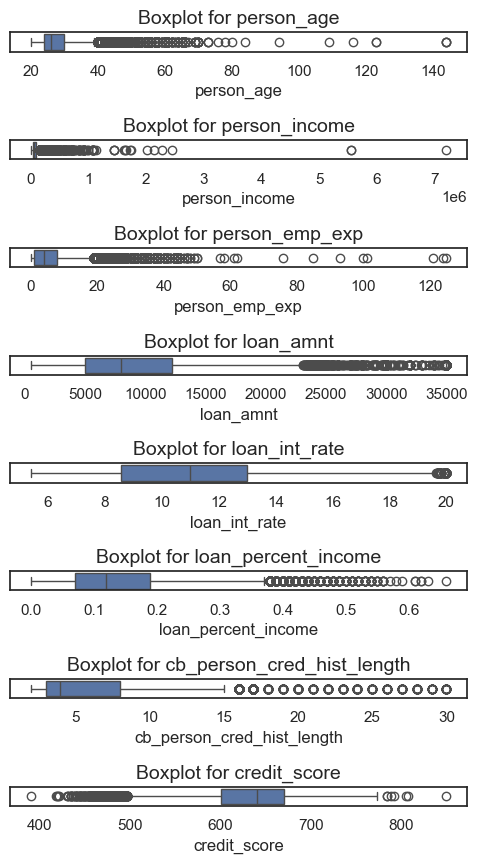

In [27]:
# Before removing the outliers
# Plot boxplot of numerical value

numerical_features = ['person_age',
                   'person_income',
                   'person_emp_exp',
                   'loan_amnt',
                   'loan_int_rate',
                   'loan_percent_income',
                   'cb_person_cred_hist_length',
                   'credit_score']

plt.figure(figsize=(5, len(numerical_features) * 1.1 ))  # adjust the plot size

for i, col in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, i + 1)  
    sns.boxplot(x = data[col])
    plt.title(f'Boxplot for {col}', fontsize = 14)

plt.tight_layout()
plt.show()

In [28]:
def remove_outliers_iqr_batch(df, columns):
    
    for column in columns:
        Q1 = df[column].quantile(0.25)  # 1st quartile
        Q3 = df[column].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = (Q1 - 1.5 * IQR).round(2)  # Lower bound
        upper_bound = (Q3 + 1.5 * IQR).round(2)  # Upper bound
        
        # Filter out values outside the range
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

In [29]:
data_cleaned = remove_outliers_iqr_batch(data, numerical_features)

# Check the results of the cleaning process
print(f"Original dataset size: {len(data)}")
print(f"Dataset size after cleaning: {len(data_cleaned)}")

Original dataset size: 45000
Dataset size after cleaning: 36269


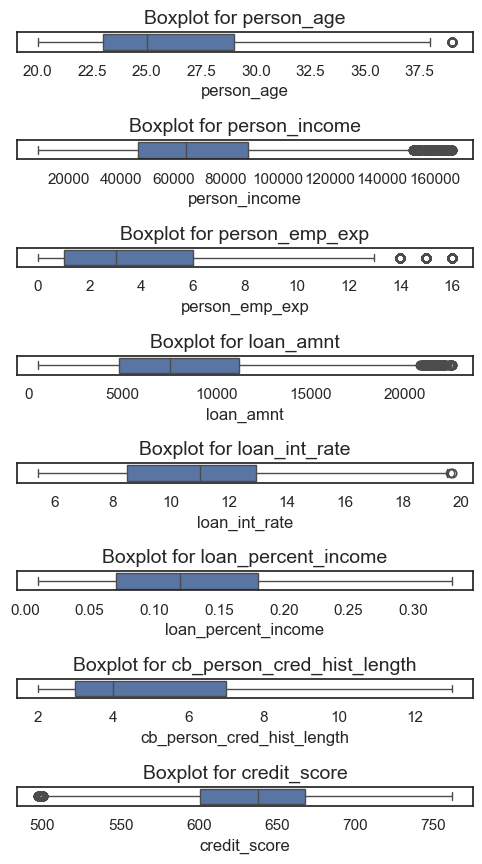

In [30]:
# Plot boxplot of numerical value
plt.figure(figsize=(5, len(numerical_features) * 1.1 ))  # adjust the plot size
for i, col in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 1, i + 1)  
    sns.boxplot(x = data_cleaned[col])
    plt.title(f'Boxplot for {col}', fontsize = 14)

plt.tight_layout()
plt.show()

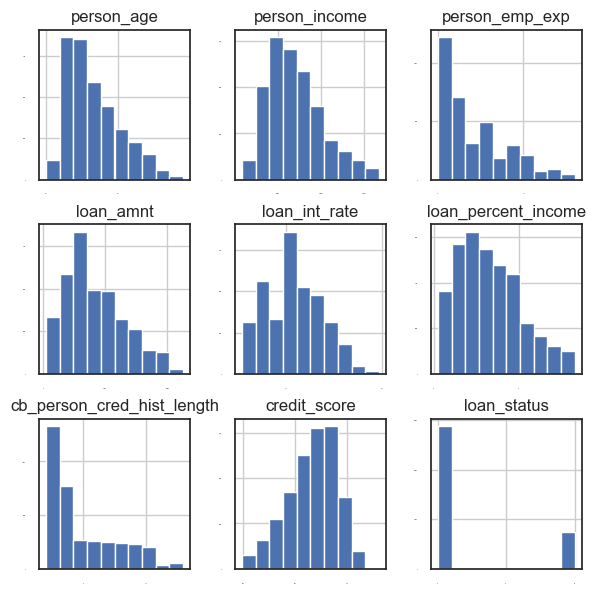

In [7]:
# Plot the histogram of the numerical values
data_cleaned.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize = 1, figsize = (7,7))
pyplot.show()

In [8]:
# Variables that require log transformation
log_transform_vars = ['person_income', 'loan_amnt', 'loan_percent_income']

# Check if variables contain 0 or negative values, and apply log(1+x) transformation
for var in log_transform_vars:
    if (data_cleaned[var] <= 0).any():
        print(f"Variable {var} contains 0 or negative values.")
    else:
        print(f"Variable {var} does not contain 0 or negative values. Applying log(x) transformation.")
        data_cleaned[f"{var}_log"] = np.log(data_cleaned[var])  # log(x)
        data_cleaned.drop(columns=log_transform_vars)


Variable person_income does not contain 0 or negative values. Applying log(x) transformation.
Variable loan_amnt does not contain 0 or negative values. Applying log(x) transformation.
Variable loan_percent_income does not contain 0 or negative values. Applying log(x) transformation.


In [9]:
data_cleaned.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,person_income_log,loan_amnt_log,loan_percent_income_log
1,21,female,High School,12282,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0,9.415890,6.907755,-2.525729
5,21,female,High School,12951,0,OWN,2500,VENTURE,7.14,0.19,2,532,No,1,9.468928,7.824046,-1.660731
9,21,female,High School,12739,0,OWN,1600,VENTURE,14.74,0.13,3,640,No,1,9.452423,7.377759,-2.040221
19,24,female,Master,14283,1,MORTGAGE,1750,EDUCATION,10.99,0.12,2,679,No,1,9.566825,7.467371,-2.120264
23,24,female,Bachelor,13866,0,OWN,1500,PERSONAL,7.29,0.11,3,600,Yes,0,9.537195,7.313220,-2.207275


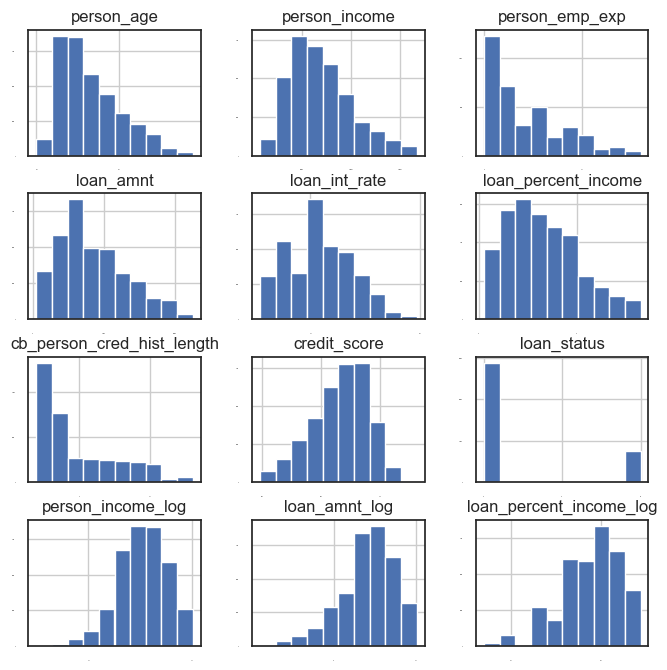

In [ ]:
data_cleaned.hist(sharex = False, sharey = False, xlabelsize = 1, ylabelsize = 1, figsize = (8,8))
pyplot.show()

In [11]:
data_cleaned = data_cleaned.reset_index(drop=True)
data_cleaned.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status',
       'person_income_log', 'loan_amnt_log', 'loan_percent_income_log'],
      dtype='object')

In [ ]:
# encode the categorical data
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
encoder = OneHotEncoder(sparse_output = False, drop = 'first')

# Encode on categorical data
encoded_data = encoder.fit_transform(data_cleaned[categorical_columns])

# Turns the categorical data into DataFrame，and set column names
encoded_columns = encoder.get_feature_names_out(categorical_columns)

encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Concatenate the encoded columns with the original data 
df = pd.concat([data_cleaned.drop(columns=categorical_columns), encoded_df], axis=1)

df

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_income_log,...,person_education_Master,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
0,21,12282,0,1000,11.14,0.08,2,504,0,9.415890,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,21,12951,0,2500,7.14,0.19,2,532,1,9.468928,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,21,12739,0,1600,14.74,0.13,3,640,1,9.452423,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,24,14283,1,1750,10.99,0.12,2,679,1,9.566825,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,24,13866,0,1500,7.29,0.11,3,600,0,9.537195,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36264,31,136832,9,12319,16.92,0.09,7,722,1,11.826509,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
36265,27,35512,4,5000,15.83,0.14,5,505,1,10.477626,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
36266,27,47971,6,15000,15.66,0.31,3,645,1,10.778352,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
36267,33,56942,7,2771,10.02,0.05,10,668,1,10.949788,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Check if classes are balanced or not
result_class_names = {0:'Rejected', 1:'Approved'}
print(data_cleaned.loan_status.value_counts().rename(index = result_class_names))

loan_status
Rejected    28830
Approved     7439
Name: count, dtype: int64


In [14]:
7439/(7439+28830)

0.20510628911742812

<Axes: >

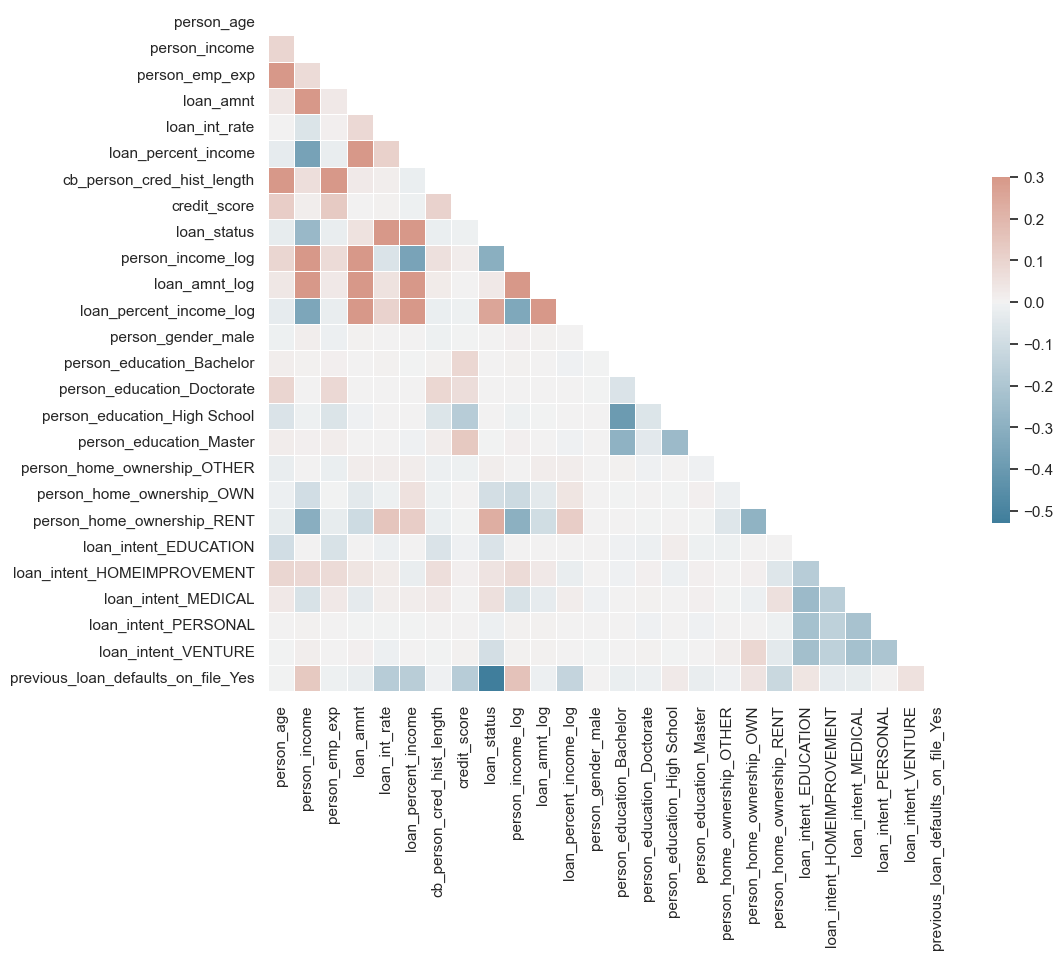

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
# splitting features and label
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 34)

# Standard scalar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure X is a DataFrame
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [41]:
##### Imbalance problem test solution

### Trying for oversampling using SMOTE
### result shows ROC-AUC score is  0.9569888137225424 in Decision Tree model
### not higher than the unprocessed slightly imbalanced data (0.962144978726638)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 34)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#########################################
#########################################

### Trying for downsampling
### result shows ROC-AUC score is 0.9593316267088065 in Decision Tree model, 
### not higher than the unprocessed slightly imbalanced data (0.962144978726638)

from sklearn.utils import resample

# Combine the training set into a single DataFrame, including features and target variable
train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)

# Separate the majority and minority classes
# Replace 'loan_status' with the name of your target column
majority_class = train_data[train_data['loan_status'] == 0]  # Majority class
minority_class = train_data[train_data['loan_status'] == 1]  # Minority class

# Perform downsampling on the majority class
majority_downsampled = resample(
    majority_class,
    replace=False,           # Without replacement
    n_samples=len(minority_class),  # Match the number of minority class samples
    random_state=34          # Ensure reproducibility
)

# Combine the downsampled majority class with the minority class
downsampled_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=34).reset_index(drop=True)

# Separate features and target variable
X_train_downsampled = downsampled_data.drop('loan_status', axis=1)
y_train_downsampled = downsampled_data['loan_status']

# Check the class distribution after downsampling
print("Original training set class distribution:")
print(y_train.value_counts())
print("\nDownsampled training set class distribution:")
print(y_train_downsampled.value_counts())

Original training set class distribution:
loan_status
0    23117
1     5898
Name: count, dtype: int64

Downsampled training set class distribution:
loan_status
0    5898
1    5898
Name: count, dtype: int64


In [62]:
# Instantiate a decision tree model with random seed of 34
dt_model = DecisionTreeClassifier(random_state = 34)

# Setting the hyperparameter grid
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf':[10, 20, 30, 50, 80, 100, 200, 300, 400, 500, 800],
              'criterion':['gini', 'entropy']}

# Instantiate the GridSearchCV object: dt_cv
dt_cv = GridSearchCV(dt_model, param_grid, cv = 5, scoring = 'roc_auc')
dt_cv.fit(X_train, y_train)

# Print the tuned parameters and score
best_dt_model = dt_cv.best_estimator_
print("Tuned Decision Tree Parameters: {}".format(dt_cv.best_params_)) 
print("Best score is {}".format(dt_cv.best_score_))

# Predict
y_pred = best_dt_model.predict(X_test)
y_prob = best_dt_model.predict_proba(X_test)[:, 1]

# Report performance
print("Decision Tree Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 80}
Best score is 0.9615853551069581
Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5713
           1       0.87      0.71      0.78      1541

    accuracy                           0.92      7254
   macro avg       0.90      0.84      0.86      7254
weighted avg       0.91      0.92      0.91      7254

ROC AUC Score: 0.962144978726638


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


<Axes: xlabel='Predicted', ylabel='Actual'>

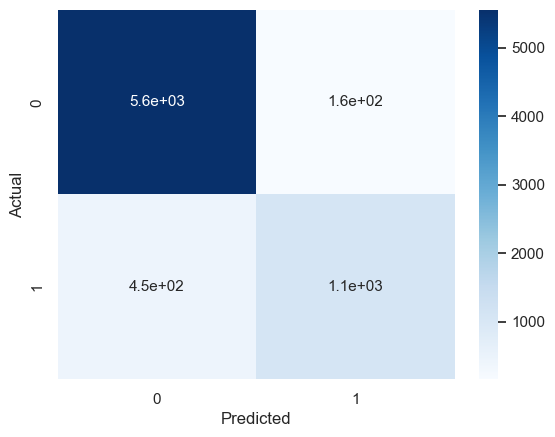

In [43]:
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 11})

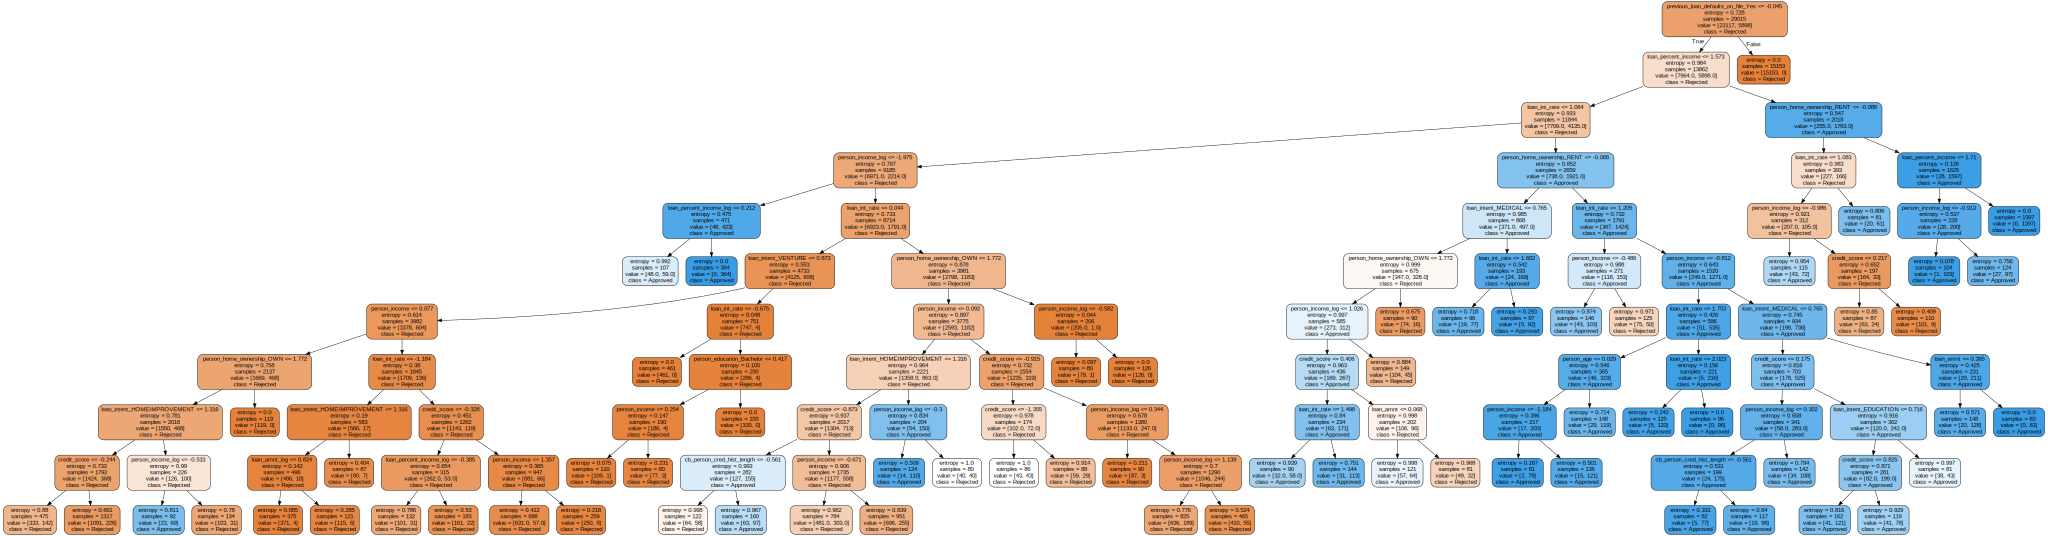

In [63]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    best_dt_model,
    out_file = None,
    feature_names = X.columns,
    class_names = ["Rejected", "Approved"],
    filled = True,
    rounded=True
)

# Use graphviz to plot the model
graph = graphviz.Source(dot_data)
graph

In [50]:
# SVM model
svm_model = SVC(probability=True, random_state=34)

# Hyperparameter distributions
param_distributions = {
    'C': [0.1, 1, 10, 100],  
    'gamma': [0.001, 0.01, 0.1, 1],  
    'kernel': ['linear', 'rbf']  # Different kernel types
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    random_state=34,
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)

# Run randomized search
random_search.fit(X_train, y_train)

# Best parameters and model
best_svm_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Predictions
y_pred = best_svm_model.predict(X_test)
y_prob = best_svm_model.predict_proba(X_test)[:, 1]

# Performance evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time= 1.4min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time= 1.4min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time= 1.4min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=21.3min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=21.3min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=22.0min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=34.8min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=34.8min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=65.0min
[CV] END ........................C=100, gamma=1, kernel=rbf; total time=135.7min
[CV] END ........................C=100, gamma=1,

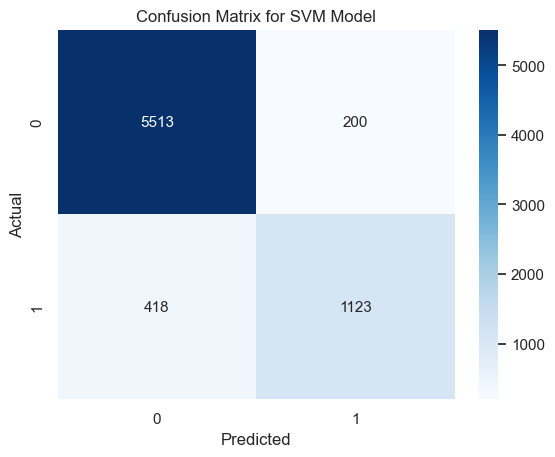

In [51]:
# Confusion matrix for SVM
df_cm_svm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=np.unique(y_test), index=np.unique(y_test))
df_cm_svm.index.name = 'Actual'
df_cm_svm.columns.name = 'Predicted'
sns.heatmap(df_cm_svm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 11})
plt.title('Confusion Matrix for SVM Model')
plt.show()

In [58]:
# Standardize the data to ensure better performance of ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
ann_model = MLPClassifier(random_state = 34, max_iter = 500)

# Define hyperparameter distributions for optimization
param_distributions = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-4, -2, 10),  # L2 regularization parameter
    'learning_rate_init': np.logspace(-3, -2, 5),  # Initial learning rate
}

# Use RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(
    estimator=ann_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
    random_state=34  # Ensure reproducibility
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from random search
best_ann_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_ann_model.predict(X_test_scaled)
y_prob = best_ann_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation report
print("Best ANN Parameters:", random_search.best_params_)
print("ANN Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.005623413251903491, solver=adam; total time=  11.7s
[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.005623413251903491, solver=adam; total time=  12.5s
[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.005623413251903491, solver=adam; total time=  13.0s
[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.005623413251903491, solver=adam; total time=  14.1s
[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.005623413251903491, solver=adam; total time=  14.8s
[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(64, 32), learning_rate_init=0.001, solver=sgd; total time=  18.2s
[CV] END activ

/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001668100537200059, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  29.9s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.003593813663804626, hidden_layer_sizes=(64, 32), learning_rate_init=0.001, solver=sgd; total time=  30.6s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001668100537200059, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  29.6s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001668100537200059, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  29.9s
[CV] END activation=relu, alpha=0.0001668100537200059, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  26.2s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  30.7s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  31.8s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  31.8s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  32.2s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  32.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.01, solver=adam; total time=  20.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.01, solver=adam; total time=  23.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.01, solver=adam; total time=  33.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.01, solver=adam; total time=  28.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.01, solver=adam; total time=  28.6s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0017782794100389228, solver=sgd; total time= 1.4min


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0017782794100389228, solver=sgd; total time= 1.4min


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0017782794100389228, solver=sgd; total time= 1.4min


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0017782794100389228, solver=sgd; total time= 1.4min
[CV] END activation=relu, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time=  17.0s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.005994842503189409, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  39.6s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001291549665014884, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0017782794100389228, solver=sgd; total time= 1.5min
[CV] END activation=relu, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time=  14.4s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.005994842503189409, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  38.5s
[CV] END activation=relu, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time=  20.2s
[CV] END activation=relu, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time=  15.4s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.005994842503189409, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  38.7s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.005994842503189409, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  38.3s


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.005994842503189409, hidden_layer_sizes=(64, 32), learning_rate_init=0.0031622776601683794, solver=sgd; total time=  38.6s
[CV] END activation=relu, alpha=0.003593813663804626, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, solver=adam; total time=  20.1s
[CV] END activation=relu, alpha=0.0002782559402207126, hidden_layer_sizes=(64, 32), learning_rate_init=0.005623413251903491, solver=adam; total time=  13.4s
[CV] END activation=relu, alpha=0.0002782559402207126, hidden_layer_sizes=(64, 32), learning_rate_init=0.005623413251903491, solver=adam; total time=  14.0s
[CV] END activation=relu, alpha=0.0002782559402207126, hidden_layer_sizes=(64, 32), learning_rate_init=0.005623413251903491, solver=adam; total time=  16.5s
[CV] END activation=tanh, alpha=0.002154434690031882, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.0017782794100389228, solver=adam; total time=  28.9s
[CV] END activation=tanh, alpha=0.002154434690031882, hidden_layer_siz

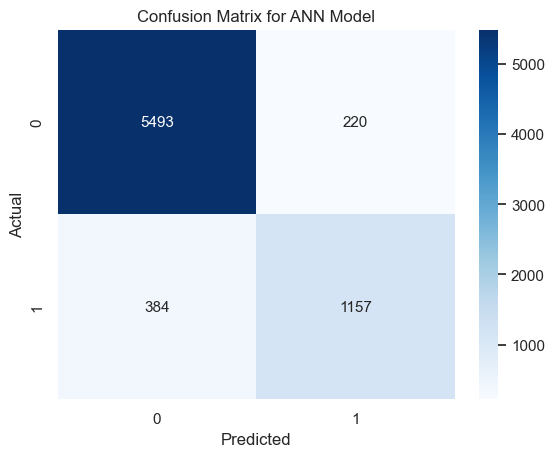

In [59]:
# Confusion matrix for ANN
df_cm_ann = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=np.unique(y_test), index=np.unique(y_test))
df_cm_ann.index.name = 'Actual'
df_cm_ann.columns.name = 'Predicted'
sns.heatmap(df_cm_ann, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 11})
plt.title('Confusion Matrix for ANN Model')
plt.show()

In [64]:
# Compare
models = ['Decision Tree', 'SVM', 'ANN']
scores = [roc_auc_score(y_test, best_dt_model.predict_proba(X_test)[:, 1]),
          roc_auc_score(y_test, best_svm_model.predict_proba(X_test)[:, 1]),
          roc_auc_score(y_test, best_ann_model.predict_proba(X_test)[:, 1])]

for model, score in zip(models, scores):
    print(f"{model}: ROC AUC Score = {score}")

Decision Tree: ROC AUC Score = 0.962144978726638
SVM: ROC AUC Score = 0.9619673268146592
ANN: ROC AUC Score = 0.9637761617713758


/Users/lucyyang/anaconda3/envs/digital_finance_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
